Project 2- Stock price prediction using historical data and recurrent neural network
Jane Anna Vickery
MATH 4377-001
Weihua Geng
12 December 2022

In [75]:
import pandas as pd    # to load dataset
import numpy as np     # for mathematic equation
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import re

For my project, I chose Microsoft (MSFT) stock to perform my regression RNN on. To obtain this data, I went to Yahoo's finance section on their website and downloaded a CSV that contained all of the information about the Microsoft stock from its opening day (1986-03-13) to the day I accessed it (2022-12-05). I chose Microsoft because I have just recently done a Finance project on the volatility of individual stocks compared to the volatility of equally weighted portfolios in Excel, so I was intrigued to see if running a regression RNN would show the same information. As you will see below, the overall dimension of the RNN is (3728,10,5) with the number of parameters being 3,728. I have 5 predictors for my original, the Open, High, Low, Close, and log_Volume columns. The response is the Closing price. 

In [57]:
# Load the dataset
my_df = pd.read_csv('MSFT.csv')
#take the log of volume in order to get numbers on a usable scale
my_df['Log_volume'] = np.log(my_df['Volume'])
columns = ['Date','Open','High','Low','Close','Volume','Log_volume']
#replace Volume with log_Volume
my_df = my_df.drop(columns = ['Volume'])

print(my_df)

            Date        Open        High         Low       Close   Adj Close  \
0     1986-03-13    0.088542    0.101563    0.088542    0.097222    0.060809   
1     1986-03-14    0.097222    0.102431    0.097222    0.100694    0.062980   
2     1986-03-17    0.100694    0.103299    0.100694    0.102431    0.064067   
3     1986-03-18    0.102431    0.103299    0.098958    0.099826    0.062437   
4     1986-03-19    0.099826    0.100694    0.097222    0.098090    0.061351   
...          ...         ...         ...         ...         ...         ...   
9254  2022-11-29  241.399994  242.789993  238.210007  240.330002  240.330002   
9255  2022-11-30  240.570007  255.330002  239.860001  255.139999  255.139999   
9256  2022-12-01  253.869995  256.119995  250.919998  254.690002  254.690002   
9257  2022-12-02  249.820007  256.059998  249.690002  255.020004  255.020004   
9258  2022-12-05  252.009995  253.820007  248.059998  250.199997  250.199997   

      Log_volume  
0      20.754560  
1

In [58]:
#ORIGINAL set with 5 predictors
# Load all needed information
L = my_df.loc[:,['Date','Open','High','Low','Close','Log_volume']]
columns = ['Open','High','Low','Close','Log_volume']

#creating 10 lagged sequences, or time steps
num_lag=10
for column in range(len(columns)):
  
    for lag in range(1,num_lag+1):
        L[str(columns[column]) + str(lag)] = L.loc[:,str(columns[column])].shift(lag)
#remove correlation between data
L=L.dropna()
print(L)

            Date        Open        High         Low       Close  Log_volume  \
10    1986-03-27    0.094618    0.096354    0.094618    0.096354   16.639743   
11    1986-03-31    0.096354    0.096354    0.093750    0.095486   16.370689   
12    1986-04-01    0.095486    0.095486    0.094618    0.094618   16.221374   
13    1986-04-02    0.094618    0.097222    0.094618    0.095486   17.111881   
14    1986-04-03    0.096354    0.098958    0.096354    0.096354   16.952742   
...          ...         ...         ...         ...         ...         ...   
9254  2022-11-29  241.399994  242.789993  238.210007  240.330002   16.703452   
9255  2022-11-30  240.570007  255.330002  239.860001  255.139999   17.677372   
9256  2022-12-01  253.869995  256.119995  250.919998  254.690002   17.075202   
9257  2022-12-02  249.820007  256.059998  249.690002  255.020004   16.884623   
9258  2022-12-05  252.009995  253.820007  248.059998  250.199997   16.969165   

           Open1       Open2       Open

As you see above, I chose to do 10 lagged sequences. Instead of doing each lagged sequence by hardcoding, which would take up a lot of time, I created a parameter, so if I wanted to change the number of lagged sequences, I would only have to change the number in one place, and it would be applied to all of my data.

In [86]:
#Since I am using regression, I've chosen before Christmas of 2000 as the data I will train on
train_X = L[L['Date'] <= "2000-12-25"]
test_X = L[L['Date'] >= "2000-12-25"]
train_y = train_X.loc[:,['Close']]
test_y = test_X.loc[:,['Close']]
print(train_X.shape)
print(test_X.shape)
train_X=train_X.drop(columns=['Close','Date','Open','High','Low','Log_volume'])
test_X=test_X.drop(columns=['Close','Date','Open','High','Low','Log_volume'])

# convert dataframe to ndarray thus reshape() is possible
train_X=train_X.values
test_X=test_X.values

train_X = train_X.reshape((train_X.shape[0], 10, 5))
test_X = test_X.reshape((test_X.shape[0], 10, 5))
print(train_X.shape)
#The overall dimension of the RNN is (3728,10,5)

(3728, 56)
(5521, 56)
(3728, 10, 5)


Epoch 1/50
52/52 - 1s - loss: 7.9995 - val_loss: 64.7999 - 1s/epoch - 27ms/step
Epoch 2/50
52/52 - 0s - loss: 9.2767 - val_loss: 65.6760 - 319ms/epoch - 6ms/step
Epoch 3/50
52/52 - 0s - loss: 8.5291 - val_loss: 65.2538 - 316ms/epoch - 6ms/step
Epoch 4/50
52/52 - 0s - loss: 8.2243 - val_loss: 64.9231 - 327ms/epoch - 6ms/step
Epoch 5/50
52/52 - 0s - loss: 7.3022 - val_loss: 63.8079 - 315ms/epoch - 6ms/step
Epoch 6/50
52/52 - 0s - loss: 6.9110 - val_loss: 63.2258 - 311ms/epoch - 6ms/step
Epoch 7/50
52/52 - 0s - loss: 6.4890 - val_loss: 62.2199 - 316ms/epoch - 6ms/step
Epoch 8/50
52/52 - 0s - loss: 7.1486 - val_loss: 62.5902 - 311ms/epoch - 6ms/step
Epoch 9/50
52/52 - 0s - loss: 6.3856 - val_loss: 61.7728 - 313ms/epoch - 6ms/step
Epoch 10/50
52/52 - 0s - loss: 6.7465 - val_loss: 61.5093 - 312ms/epoch - 6ms/step
Epoch 11/50
52/52 - 0s - loss: 6.0498 - val_loss: 60.4824 - 307ms/epoch - 6ms/step
Epoch 12/50
52/52 - 0s - loss: 6.4103 - val_loss: 60.1014 - 329ms/epoch - 6ms/step
Epoch 13/50
52/

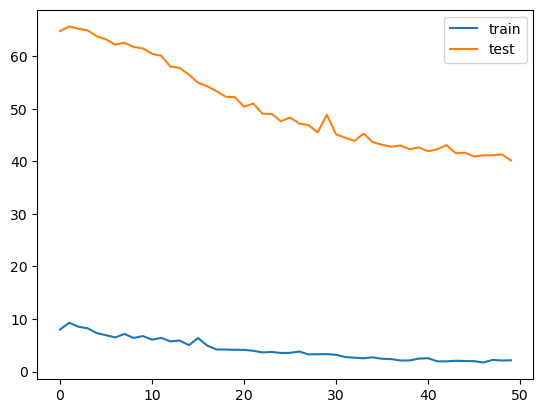

173/173 [==============================] - 0s 1ms/step
Test RMSE: 84.003


In [67]:
# design network: RELU ACTIVATION
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#I used an ReLU Activation function
model.add(Dense(1, activation = 'relu'))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Epoch 1/50
52/52 - 2s - loss: 9.2441 - val_loss: 68.6619 - 2s/epoch - 35ms/step
Epoch 2/50
52/52 - 0s - loss: 9.2441 - val_loss: 68.6619 - 355ms/epoch - 7ms/step
Epoch 3/50
52/52 - 0s - loss: 9.2441 - val_loss: 68.6619 - 334ms/epoch - 6ms/step
Epoch 4/50
52/52 - 0s - loss: 9.2441 - val_loss: 68.6619 - 313ms/epoch - 6ms/step
Epoch 5/50
52/52 - 0s - loss: 9.2441 - val_loss: 68.6619 - 318ms/epoch - 6ms/step
Epoch 6/50
52/52 - 0s - loss: 9.2441 - val_loss: 68.6619 - 316ms/epoch - 6ms/step
Epoch 7/50
52/52 - 0s - loss: 9.2441 - val_loss: 68.6619 - 315ms/epoch - 6ms/step
Epoch 8/50
52/52 - 0s - loss: 9.2441 - val_loss: 68.6619 - 320ms/epoch - 6ms/step
Epoch 9/50
52/52 - 0s - loss: 9.2441 - val_loss: 68.6619 - 313ms/epoch - 6ms/step
Epoch 10/50
52/52 - 0s - loss: 9.2441 - val_loss: 68.6619 - 315ms/epoch - 6ms/step
Epoch 11/50
52/52 - 0s - loss: 9.2441 - val_loss: 68.6619 - 315ms/epoch - 6ms/step
Epoch 12/50
52/52 - 0s - loss: 9.2441 - val_loss: 68.6619 - 313ms/epoch - 6ms/step
Epoch 13/50
52/

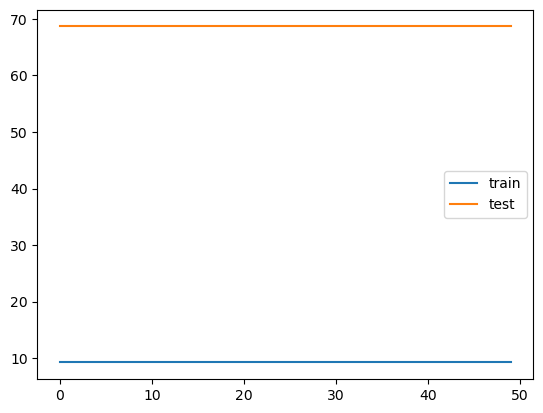

173/173 [==============================] - 0s 1ms/step
Test RMSE: 102.608


In [84]:
# design network with SOFTMAX
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#I used an softmax Activation function
model.add(Dense(1, activation = 'softmax'))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

In [89]:
#Second set with 4 predictors
# Load all needed information
L = my_df.loc[:,['Date','Open','High','Low','Close']]
columns = ['Open','High','Low','Close']

#creating 10 lagged sequences, or time steps
num_lag=10
for column in range(len(columns)):
  
    for lag in range(1,num_lag+1):
        L[str(columns[column]) + str(lag)] = L.loc[:,str(columns[column])].shift(lag)
#remove correlation between data
L=L.dropna()
print(L)

            Date        Open        High         Low       Close       Open1  \
10    1986-03-27    0.094618    0.096354    0.094618    0.096354    0.092014   
11    1986-03-31    0.096354    0.096354    0.093750    0.095486    0.094618   
12    1986-04-01    0.095486    0.095486    0.094618    0.094618    0.096354   
13    1986-04-02    0.094618    0.097222    0.094618    0.095486    0.095486   
14    1986-04-03    0.096354    0.098958    0.096354    0.096354    0.094618   
...          ...         ...         ...         ...         ...         ...   
9254  2022-11-29  241.399994  242.789993  238.210007  240.330002  246.080002   
9255  2022-11-30  240.570007  255.330002  239.860001  255.139999  241.399994   
9256  2022-12-01  253.869995  256.119995  250.919998  254.690002  240.570007   
9257  2022-12-02  249.820007  256.059998  249.690002  255.020004  253.869995   
9258  2022-12-05  252.009995  253.820007  248.059998  250.199997  249.820007   

           Open2       Open3       Open

Epoch 1/50
52/52 - 2s - loss: 9.8835 - val_loss: 69.6619 - 2s/epoch - 36ms/step
Epoch 2/50
52/52 - 0s - loss: 9.8835 - val_loss: 69.6619 - 333ms/epoch - 6ms/step
Epoch 3/50
52/52 - 0s - loss: 9.8835 - val_loss: 69.6619 - 333ms/epoch - 6ms/step
Epoch 4/50
52/52 - 0s - loss: 9.8835 - val_loss: 69.6619 - 316ms/epoch - 6ms/step
Epoch 5/50
52/52 - 0s - loss: 9.8835 - val_loss: 69.6619 - 314ms/epoch - 6ms/step
Epoch 6/50
52/52 - 0s - loss: 9.8835 - val_loss: 69.6619 - 312ms/epoch - 6ms/step
Epoch 7/50
52/52 - 0s - loss: 9.8835 - val_loss: 69.6619 - 315ms/epoch - 6ms/step
Epoch 8/50
52/52 - 0s - loss: 9.8835 - val_loss: 69.6619 - 313ms/epoch - 6ms/step
Epoch 9/50
52/52 - 0s - loss: 9.8835 - val_loss: 69.6619 - 324ms/epoch - 6ms/step
Epoch 10/50
52/52 - 0s - loss: 9.8835 - val_loss: 69.6619 - 312ms/epoch - 6ms/step
Epoch 11/50
52/52 - 0s - loss: 9.8835 - val_loss: 69.6619 - 315ms/epoch - 6ms/step
Epoch 12/50
52/52 - 0s - loss: 9.8835 - val_loss: 69.6619 - 314ms/epoch - 6ms/step
Epoch 13/50
52/

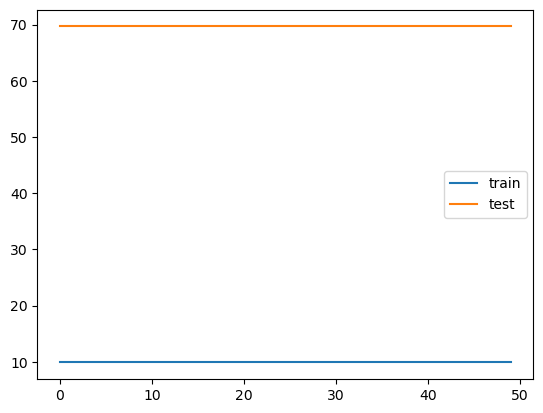

173/173 [==============================] - 0s 1ms/step
Test RMSE: 103.280


In [90]:
# design network: RELU ACTIVATION with 4 predictors
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#I used an ReLU Activation function
model.add(Dense(1, activation = 'relu'))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

In [91]:
#Thid set with 2 predictors
# Load all needed information
L = my_df.loc[:,['Date','Open','Close']]
columns = ['Open','Close']

#creating 10 lagged sequences, or time steps
num_lag=10
for column in range(len(columns)):
  
    for lag in range(1,num_lag+1):
        L[str(columns[column]) + str(lag)] = L.loc[:,str(columns[column])].shift(lag)
#remove correlation between data
L=L.dropna()
print(L)

            Date        Open       Close       Open1       Open2       Open3  \
10    1986-03-27    0.094618    0.096354    0.092014    0.090278    0.092882   
11    1986-03-31    0.096354    0.095486    0.094618    0.092014    0.090278   
12    1986-04-01    0.095486    0.094618    0.096354    0.094618    0.092014   
13    1986-04-02    0.094618    0.095486    0.095486    0.096354    0.094618   
14    1986-04-03    0.096354    0.096354    0.094618    0.095486    0.096354   
...          ...         ...         ...         ...         ...         ...   
9254  2022-11-29  241.399994  240.330002  246.080002  247.309998  245.110001   
9255  2022-11-30  240.570007  255.139999  241.399994  246.080002  247.309998   
9256  2022-12-01  253.869995  254.690002  240.570007  241.399994  246.080002   
9257  2022-12-02  249.820007  255.020004  253.869995  240.570007  241.399994   
9258  2022-12-05  252.009995  250.199997  249.820007  253.869995  240.570007   

           Open4       Open5       Open

Epoch 1/50
52/52 - 2s - loss: 7.5762 - val_loss: 64.2890 - 2s/epoch - 34ms/step
Epoch 2/50
52/52 - 0s - loss: 9.4990 - val_loss: 65.6765 - 344ms/epoch - 7ms/step
Epoch 3/50
52/52 - 0s - loss: 8.5925 - val_loss: 65.5217 - 316ms/epoch - 6ms/step
Epoch 4/50
52/52 - 0s - loss: 8.4013 - val_loss: 65.3519 - 312ms/epoch - 6ms/step
Epoch 5/50
52/52 - 0s - loss: 7.6424 - val_loss: 64.7581 - 332ms/epoch - 6ms/step
Epoch 6/50
52/52 - 0s - loss: 7.0650 - val_loss: 63.6551 - 314ms/epoch - 6ms/step
Epoch 7/50
52/52 - 0s - loss: 6.9900 - val_loss: 62.7745 - 314ms/epoch - 6ms/step
Epoch 8/50
52/52 - 0s - loss: 6.7351 - val_loss: 62.0258 - 324ms/epoch - 6ms/step
Epoch 9/50
52/52 - 0s - loss: 6.5213 - val_loss: 61.5186 - 315ms/epoch - 6ms/step
Epoch 10/50
52/52 - 0s - loss: 5.9662 - val_loss: 60.2418 - 315ms/epoch - 6ms/step
Epoch 11/50
52/52 - 0s - loss: 6.3837 - val_loss: 59.8178 - 313ms/epoch - 6ms/step
Epoch 12/50
52/52 - 0s - loss: 5.6350 - val_loss: 58.8114 - 315ms/epoch - 6ms/step
Epoch 13/50
52/

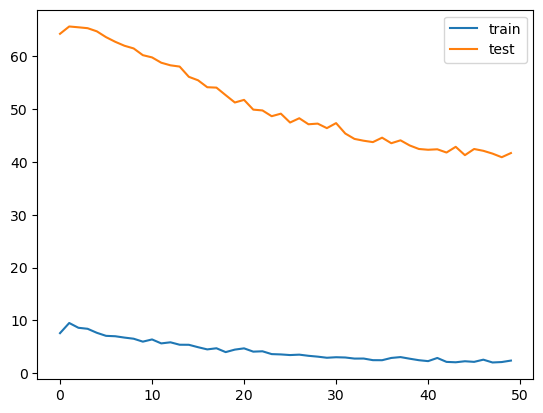

173/173 [==============================] - 0s 1ms/step
Test RMSE: 85.644


In [92]:
# design network: RELU ACTIVATION with 2 predictors
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#I used an ReLU Activation function
model.add(Dense(1, activation = 'relu'))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

In [85]:
# Summarize the built model
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 50)                11200     
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


Yes, I used LSTM. The number of related parameters is 11,200. I decided to use LSTM because with long sequences, this overcomes the problem of early signals being washed out by the time they get propagated through the chain to the final activation vector. 

The total number of neurons in the hidden layer is 11,251.

Now, for an interpretation of the performance of my model. The Test RMSE tells us how close the observed data points are to the model's predicted values. Obviously, we want the RMSE to be as low as possible. With my data, I played around with different factors such as the type of activation function and the number of predictors to test how RMSE differs based on each of the factors. Here, I will discuss the results.

As seen above, I computed two different models with respect to the type of activation function. First, I used reLU activation function in the hidden layer. This gave me an RMSE of 84.003. While this number seems very high, it should also be taken into account the large amount of data we have. However, when I use the softmax activation function in the hidden layer, the RMSE goes up to 102.608. I believe this is because the softmax function not only works best in classification problems but also exclusively in the output layer. Therefore, it makes sense that the RMSE is higher because this is a regression problem. Hence, I would choose to stick with reLU activation function in this regression problem not only for the reason that it is more popular for its effciency and computability, but also for its compatibility.

Also, I played a little around with the number of predictors, I got some interesting results. With my original data, I have 5 predictors, the RMSE is 84.003. However, when I dropped log_Volume as a predictor, the RMSE shot up to 103.280. Because of this, I figured that reducing the number of parameters to 2 would make the RMSE increase even more. However, this was not the case. When I dropped to only 2 parameters, Open and Close, the RMSE went down to 85.644. I found this very interesting, but as I started thinking I made the connection that by just removing log_Volume as a predictor, the model becomes less accurate, meaning that log_Volume does have a say in the prediction of the closing price. However, when I also removed the High and Low data as parameters, the RMSE went back down. This tells me log_Volume, High, Low data points all impact each other. By removing all 3 of those parameters, I was able to get my RMSE closer to that with 5 parameters. Even though this seemed counterintuitive to me, it made me realize that certain variables have differnet impacts on each other, and I think that the best way to lower your RMSE would be to play around with different combinations of predictors to see which relationships have the most tell of the data. 

Even after trying to optimize the model with playing around with different factors, it still seems that my original plan of 5 parameters brings the lowest test RMSE. 

Conclusion

Overall, I learned that stock price prediction using historical data and recurrent neural network is a very difficult task. After all, if it was easy, then everyone would be a millionaire! However, I did learn some ways to make my model more accurate, such as playing around with different predictors and how they respond to each other. Even though the lowest test RMSE I could ever achieve was 84.003, it shows that out of all of the models I tested, 5 parameters with reLU activation function proved to have the strongest relation between actual and predicted stock price. In the future, I would be interested in creating a portfolio and running the same type of regression to compare the test RMSE. 